# Preface:
First of all, prerequired modules and packages are imported 
and the default options for plot are set.

In [1]:
import time
import warnings
import pickle
import io, requests, zipfile
#####
import numpy as np
#from numba import jit, prange
import pandas as pd
import matplotlib.pyplot as plt
import qutip as Q
#####
from scipy.optimize import minimize
from scipy.stats import expon
#####
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler # scale
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.decomposition import PCA
#####
from sklearn.model_selection import train_test_split ,  cross_val_score , cross_validate, learning_curve## only one split, cv split only scores, cv split scores and more info, cross_validate on different train_sizes
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV , validation_curve # on params
#####
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#####
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
#####
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBClassifier
#from mlxtend.classifier import StackingClassifier
#####
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix,  classification_report #cnfmatrix = confusion_matrix(Y,predicted_Y)
from sklearn.metrics import precision_recall_curve , roc_curve

In [2]:
'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 3 )

plt.rc('lines', markersize = 5 )

plt.rc('figure', figsize=(8,4) )         # Image size

warnings.filterwarnings("ignore") #ignore warnings

# Data Generation :

The method used for data generation is to use qutip module and generate a Random Density Matrice and then Calculate the 
Measurements on the Generated Density Matrice 


by calculating the determinant of the parital transposed density matrix, it can be de decided whether the state is entangled or not.

The matrix of features is in the form:

 $$Features = \begin{bmatrix}
\sigma_x\otimes\sigma_x & \sigma_x\otimes\sigma_y & \sigma_x\otimes\sigma_z & \sigma_x\otimes\ \mathbb{1} 
\\ \sigma_y\otimes\sigma_x & \sigma_y\otimes\sigma_y & \sigma_y\otimes\sigma_z & \sigma_y\otimes\ \mathbb{1}
\\ \sigma_z\otimes\sigma_x & \sigma_z\otimes\sigma_y & \sigma_z\otimes\sigma_z & \sigma_z\otimes\ \mathbb{1}
\\ \mathbb{1}\otimes\sigma_x & \mathbb{1}\otimes\sigma_y & \mathbb{1}\otimes\sigma_z & \mathbb{1}\otimes\ \mathbb{1}
\end{bmatrix}$$

The features are then reformed to (15 , 1) shape where $$ \mathbb{1} \otimes \mathbb{1} $$ feature is ommited since it's always 1.


The following function 'data_gen' recieves 'N' of type int, the number of samples to generate, and 'verbose' of type int, the vorbosity to report during generation.

return type is a tuple of numpy.array which returns (x,y,yc) where x is the matrix for the features, y is determinant of partial transposed matrix and yc is a binary '0' for seprable and '1' for entangled states.

In [3]:
# (Number of samples (int)) -> (x,y,yc)
#O(n) , 10000 = 40s
def data_gen(N = 50000, verbose = -1):
  tim = time.time()
  sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
  f = np.empty((4,4))
  x = np.empty((N,15))
  y = np.empty(N)
  yc = np.empty(N,dtype=np.int64)

  for k in range(N):
    rho1 = Q.rand_dm(4,dims=[ [2,2] , [2,2] ] )
    for i in range(4):
      for j in range(4):
        f[i,j] = (rho1* Q.tensor(sigma[i],sigma[j])).tr().real
    x[k] = np.delete(f.reshape(1,16),15)
    rho2 = Q.partial_transpose(rho1, [0,1] )
    y[k] = np.linalg.det(rho2.full()).real
    if y[k] < 0 :
      yc[k]=1 #Entangled
    else:
      yc[k]=0 #Separable
    if (k+1) % (N/verbose) == 0 : print('Number of data generated : {}   , time elapsed : {} min , {} sec'.format(k+1,
                                                                                                                  int(time.time()-tim)//60,
                                                                                                                  int(time.time()-tim)%60) )  
  y=y.reshape(N,1)

  operators = ('sigma_x' , 'sigma_y' , 'sigma_z' , 'I' )
  columns = ['{} {}'.format(i,j) for i in operators for j in operators]
  del columns[-1]
  xd = pd.DataFrame(x,columns=columns)
  yd = pd.DataFrame(y,columns=['determinant'])
  ycd = pd.DataFrame(yc,columns=['is_entangled'])
  return pd.concat([xd,yd,ycd],axis=1)

## Generating and Saving / Loading the Data : 

we can generate and save the data in the following code:

In [4]:
# you can regenerate the data running this code 
n_samples=10000
data = data_gen(N=n_samples , verbose = 10)  
data.to_pickle('data.gz')
data.head()

Number of data generated : 1000   , time elapsed : 0 min , 6 sec
Number of data generated : 2000   , time elapsed : 0 min , 12 sec
Number of data generated : 3000   , time elapsed : 0 min , 18 sec
Number of data generated : 4000   , time elapsed : 0 min , 24 sec
Number of data generated : 5000   , time elapsed : 0 min , 29 sec
Number of data generated : 6000   , time elapsed : 0 min , 35 sec
Number of data generated : 7000   , time elapsed : 0 min , 41 sec
Number of data generated : 8000   , time elapsed : 0 min , 47 sec
Number of data generated : 9000   , time elapsed : 0 min , 52 sec
Number of data generated : 10000   , time elapsed : 0 min , 58 sec


,sigma_x sigma_x,sigma_x sigma_y,sigma_x sigma_z,sigma_x I,sigma_y sigma_x,sigma_y sigma_y,sigma_y sigma_z,sigma_y I,sigma_z sigma_x,sigma_z sigma_y,sigma_z sigma_z,sigma_z I,I sigma_x,I sigma_y,I sigma_z,determinant,is_entangled
0,0.063394,-0.030475,0.054712,-0.207182,-0.100642,-0.119281,-0.153700,-0.023325,0.153603,-0.300538,0.093314,-0.630818,-0.216680,0.398048,-0.138596,0.000616,0
1,-0.140623,0.156939,-0.097862,0.257280,-0.117338,0.358434,-0.060805,-0.193301,0.137166,-0.247568,0.386097,0.055322,0.120454,0.082775,-0.244874,-0.000829,1
2,0.442904,-0.025508,0.252517,-0.073066,0.145303,-0.178814,-0.361514,0.193291,0.241775,-0.416794,0.362798,-0.320768,-0.151865,0.054982,-0.160275,-0.005184,1
3,0.048773,-0.057124,0.175588,-0.294659,0.064488,-0.270791,0.149194,-0.020468,-0.258235,-0.292408,0.492207,-0.848040,0.258235,0.292408,-0.457389,-0.000223,1
4,0.332981,-0.228244,-0.309372,-0.270460,-0.155656,-0.288667,-0.392645,0.338129,-0.030599,-0.103525,0.117726,0.090513,-0.189008,0.057949,-0.197000,-0.001448,1


In [5]:
# or you can Load the already saved data
data = pd.read_pickle('data.gz')
data.head()

,sigma_x sigma_x,sigma_x sigma_y,sigma_x sigma_z,sigma_x I,sigma_y sigma_x,sigma_y sigma_y,sigma_y sigma_z,sigma_y I,sigma_z sigma_x,sigma_z sigma_y,sigma_z sigma_z,sigma_z I,I sigma_x,I sigma_y,I sigma_z,determinant,is_entangled
0,0.063394,-0.030475,0.054712,-0.207182,-0.100642,-0.119281,-0.153700,-0.023325,0.153603,-0.300538,0.093314,-0.630818,-0.216680,0.398048,-0.138596,0.000616,0
1,-0.140623,0.156939,-0.097862,0.257280,-0.117338,0.358434,-0.060805,-0.193301,0.137166,-0.247568,0.386097,0.055322,0.120454,0.082775,-0.244874,-0.000829,1
2,0.442904,-0.025508,0.252517,-0.073066,0.145303,-0.178814,-0.361514,0.193291,0.241775,-0.416794,0.362798,-0.320768,-0.151865,0.054982,-0.160275,-0.005184,1
3,0.048773,-0.057124,0.175588,-0.294659,0.064488,-0.270791,0.149194,-0.020468,-0.258235,-0.292408,0.492207,-0.848040,0.258235,0.292408,-0.457389,-0.000223,1
4,0.332981,-0.228244,-0.309372,-0.270460,-0.155656,-0.288667,-0.392645,0.338129,-0.030599,-0.103525,0.117726,0.090513,-0.189008,0.057949,-0.197000,-0.001448,1


In [6]:
x = data.drop(['determinant','is_entangled'],axis=1).values
y = data['determinant'].values
yc = data['is_entangled'].values
n_features=15

# Data Analysis : 

## Frequency of entangled states

In [7]:
# now we want to Calculate the percent of data which is entangled            
print("{} % of the stored data is entangled ".format(100*(yc.sum())/yc.size))

67.39 % of the stored data is entangled 


## Histograms :
The histograms of each 15 features are shown in the following figure

'Histogram'

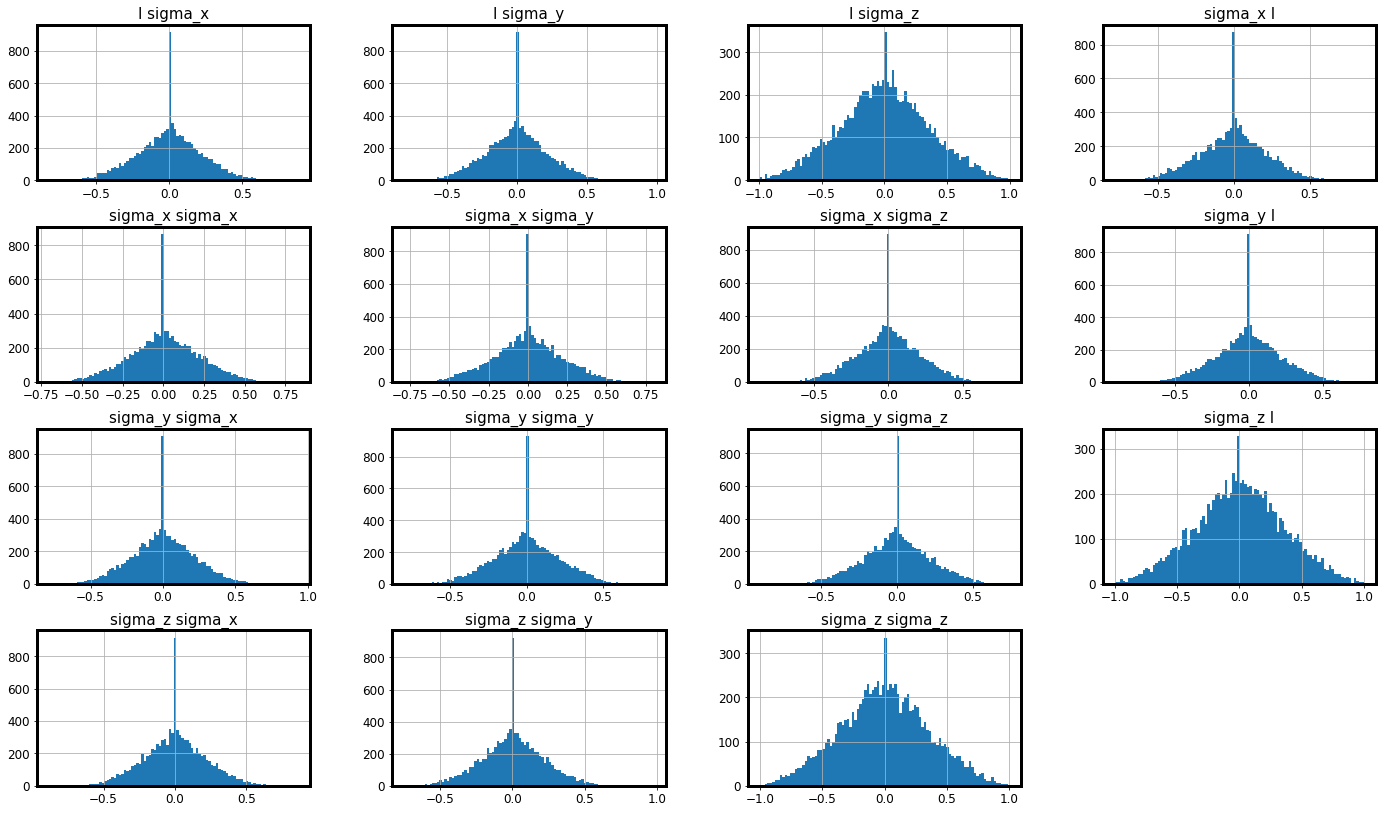

In [8]:
data.drop(['determinant','is_entangled'],axis=1).hist(figsize=(24,14),bins=100)
'Histogram'

## Entanglement and Features :

in this part we plot the Determinant of Partial Transposed Density Matrix vs.Features

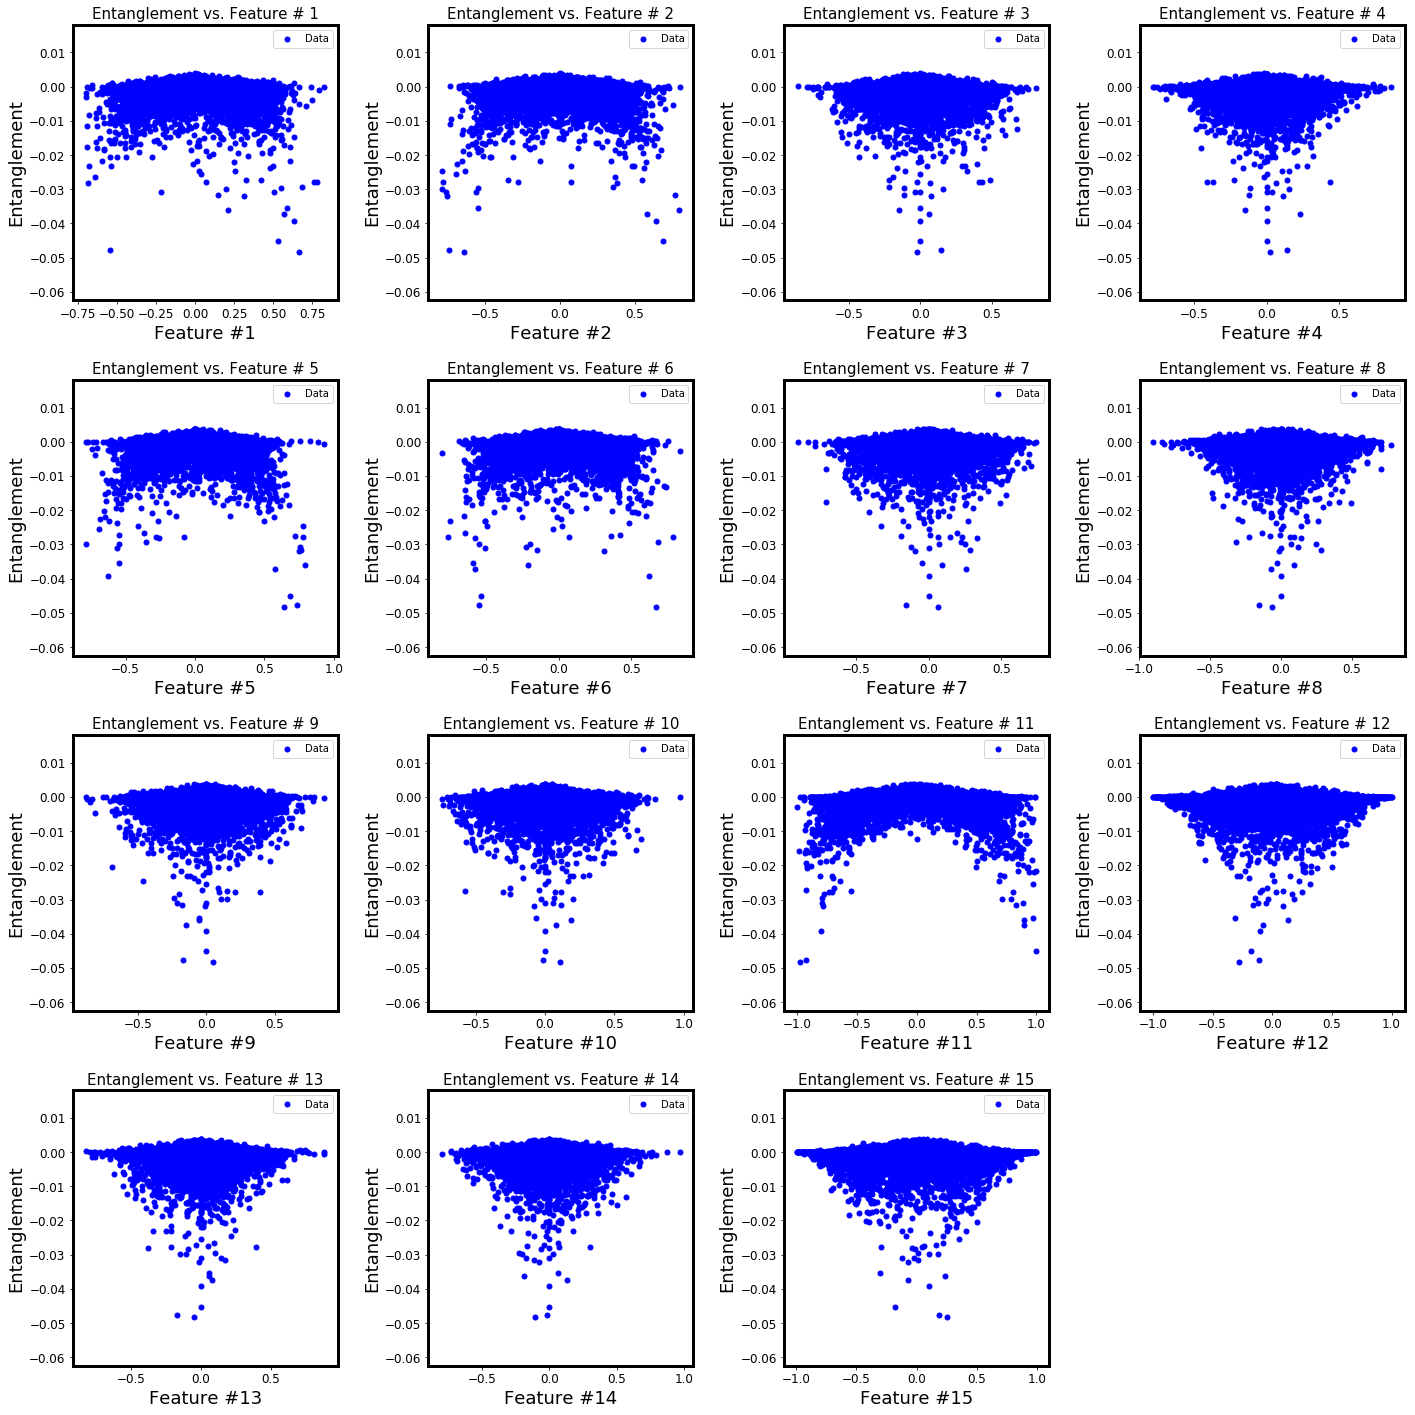

In [9]:
# without Classification
    
f = plt.figure(figsize=(20,20))
for i in range(15):
    ax = f.add_subplot(4, 4, i + 1, xlabel="Feature #" + str(i+1), ylabel='Entanglement', title="Entanglement vs. Feature # "+ str(i+1) )
    ax.scatter(x[:, i ] , y, color='b',label='Data' )
    ax.legend(loc=0, fontsize = 10)
    
plt.tight_layout()
plt.show()

## Ploting Features vs. Features :
in this section one selected feature can be plotted against the Other Features 

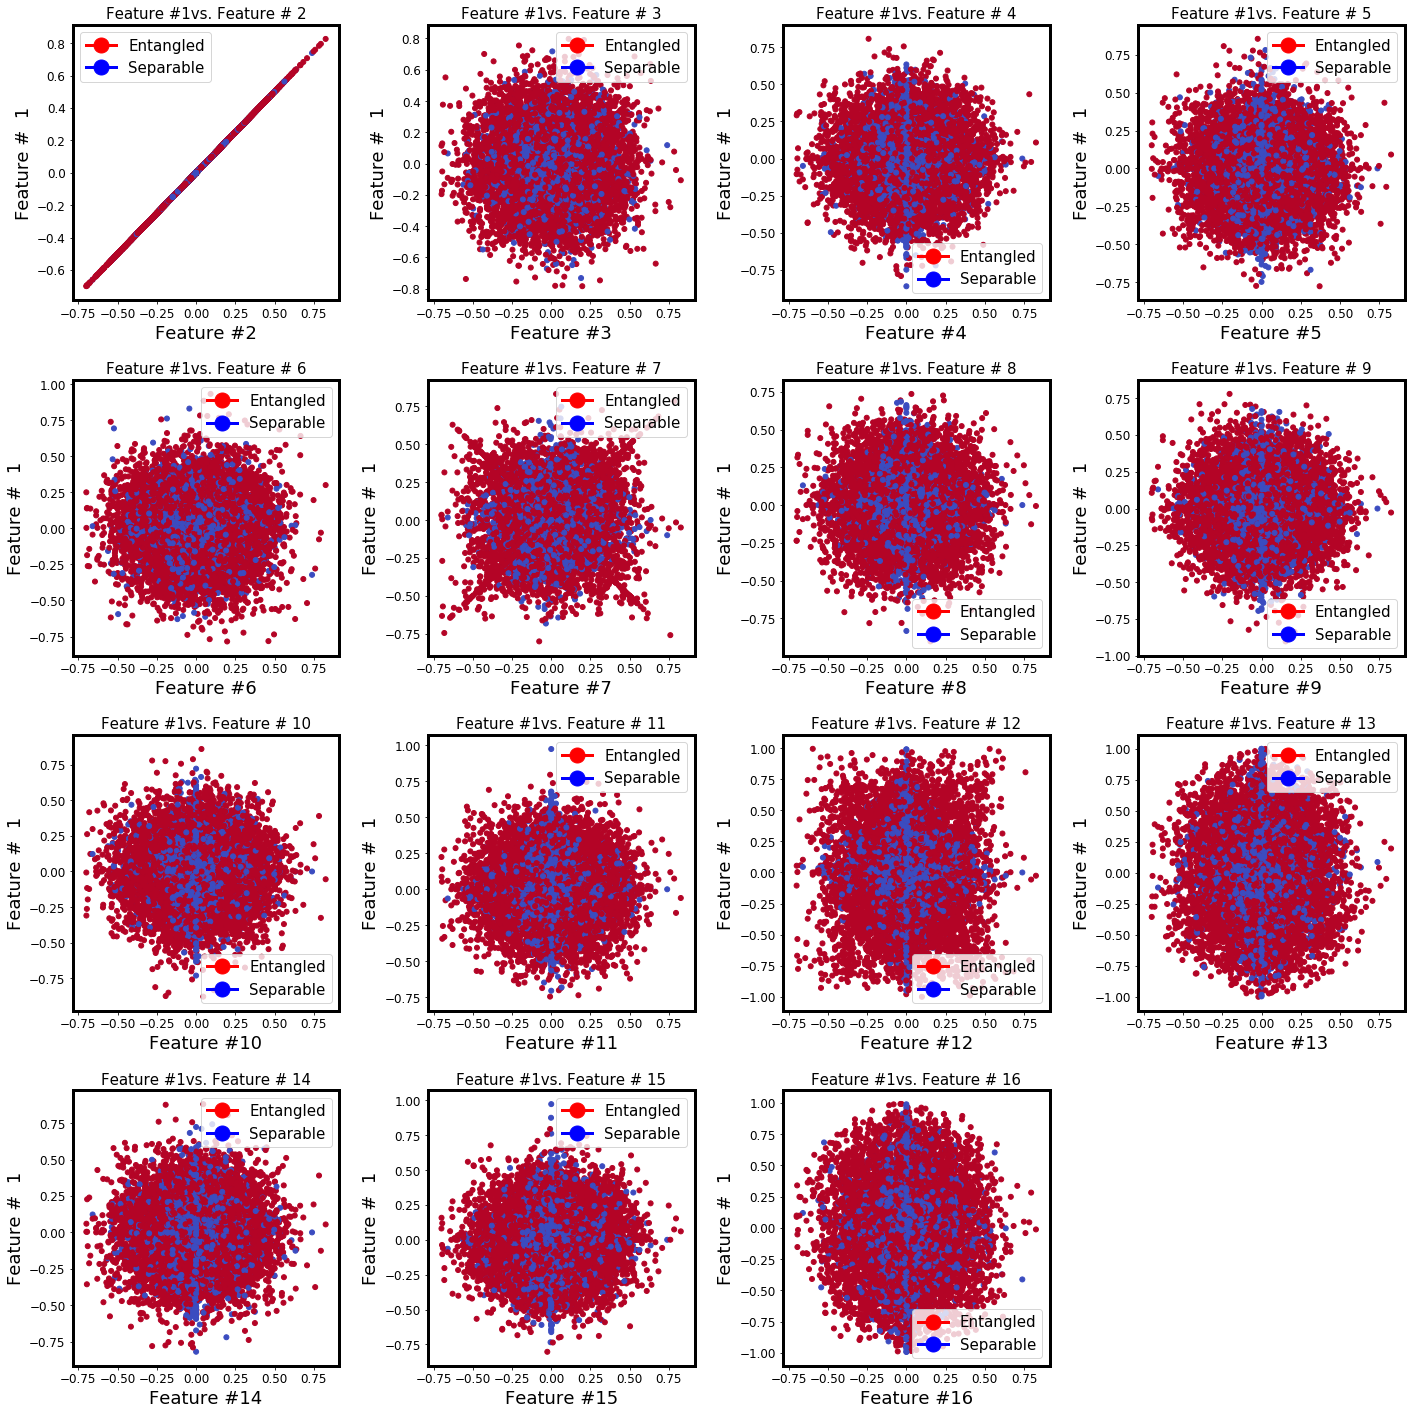

CPU times: user 23.1 s, sys: 9.51 s, total: 32.6 s
Wall time: 19.4 s


In [10]:
%%time
# with Classification Mode
sel = 0 # you can change this variable and change the selected fearue 
# the order of stored features is
# (Sx*Sx  Sx*Sy  Sx*Sz  Sx*I  )
# (Sy*Sx  Sy*Sy  Sy*Sz  Sy*I  )
# (Sz*Sx  Sz*Sy  Sz*Sz  Sz*I  )
# ( I*Sx   I*Sy   I*Sz   I*I  )

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker = 'o' , color='r' , markerfacecolor='r', markersize=15),
                Line2D([0], [0], marker = 'o' , color='b' , markerfacecolor='b', markersize=15)]

f = plt.figure(figsize=(20,20))
for i in range(15):
    ax = f.add_subplot(4, 4, i + 1, xlabel="Feature #" + str(i+2), ylabel='Feature #  '+str(sel+1), title="Feature #" +str(sel+1) + "vs. Feature # "+ str(i+2) )
    ax.scatter(x[:,sel],x[:,i], c= yc , cmap=plt.cm.coolwarm )
    ax.legend(custom_lines, ['Entangled', 'Separable'])    

plt.tight_layout()
plt.show()

## Histograms of Entangeld Data:

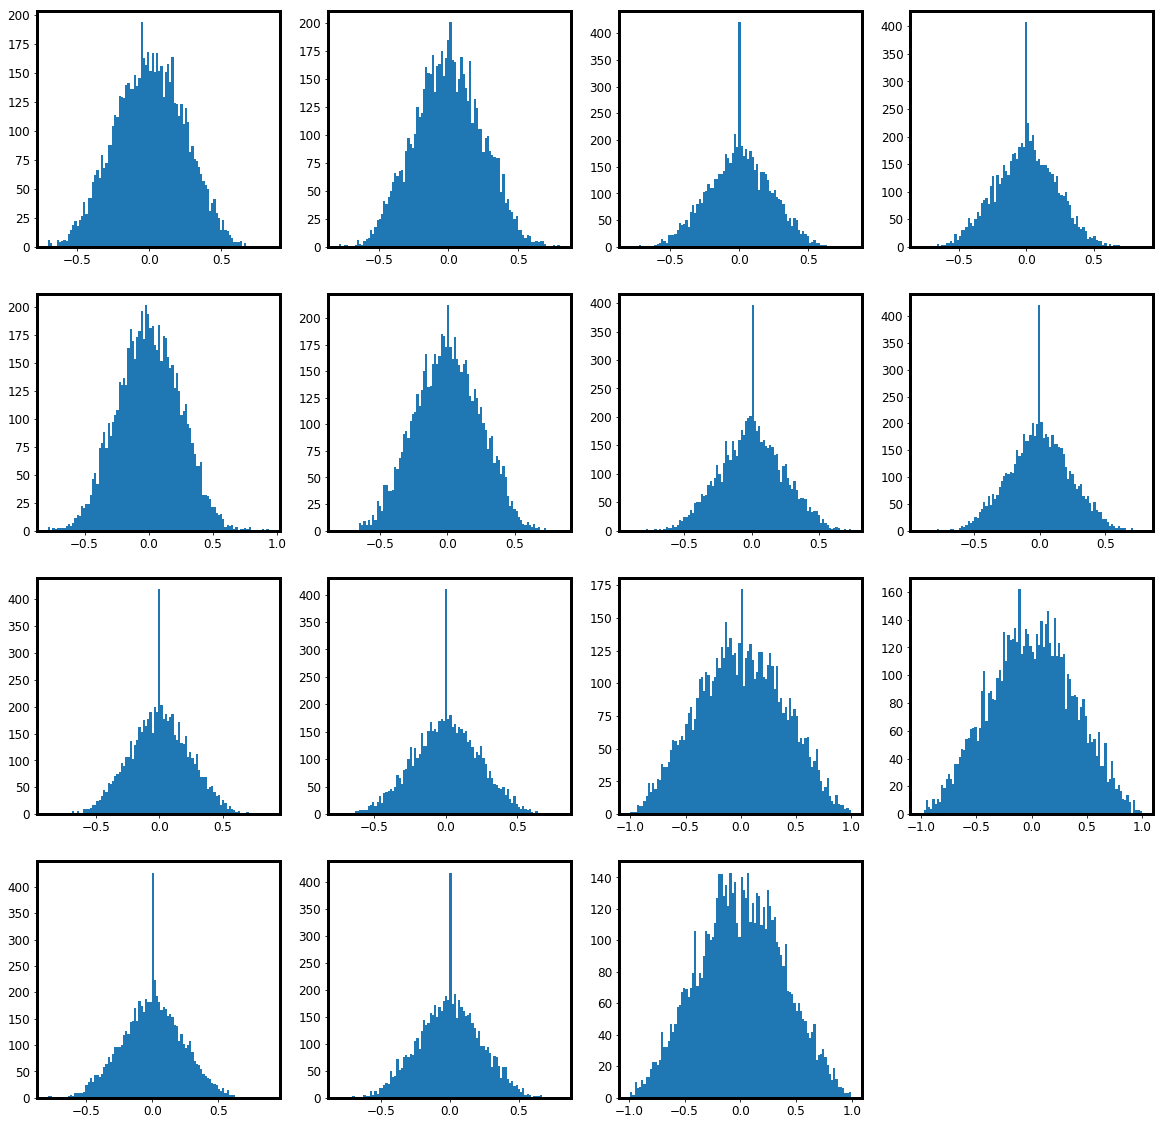

CPU times: user 7.5 s, sys: 2.6 s, total: 10.1 s
Wall time: 6.58 s


In [11]:
%%time
# Histograms
n_feature=15
dellist = []
dellistc = []
fig = plt.figure(figsize=(20,20))

for i in range (n_samples):
    if yc[i] == 1: dellistc.append(i)

for i in range (n_samples):
        if y[i] >= 0: dellist.append(i)


ent_x = np.delete( x , dellist , 0)
ent_y = np.delete( y , dellist , 0)
ent_yc = np.delete(yc,dellistc)
ax=[]
for i in range(n_feature) :
    ax.append( fig.add_subplot(4,4,i+1) )
    ax[i].hist(ent_x[:,i],bins=100)

plt.show()
#plt.tight_layout()
plt.close()


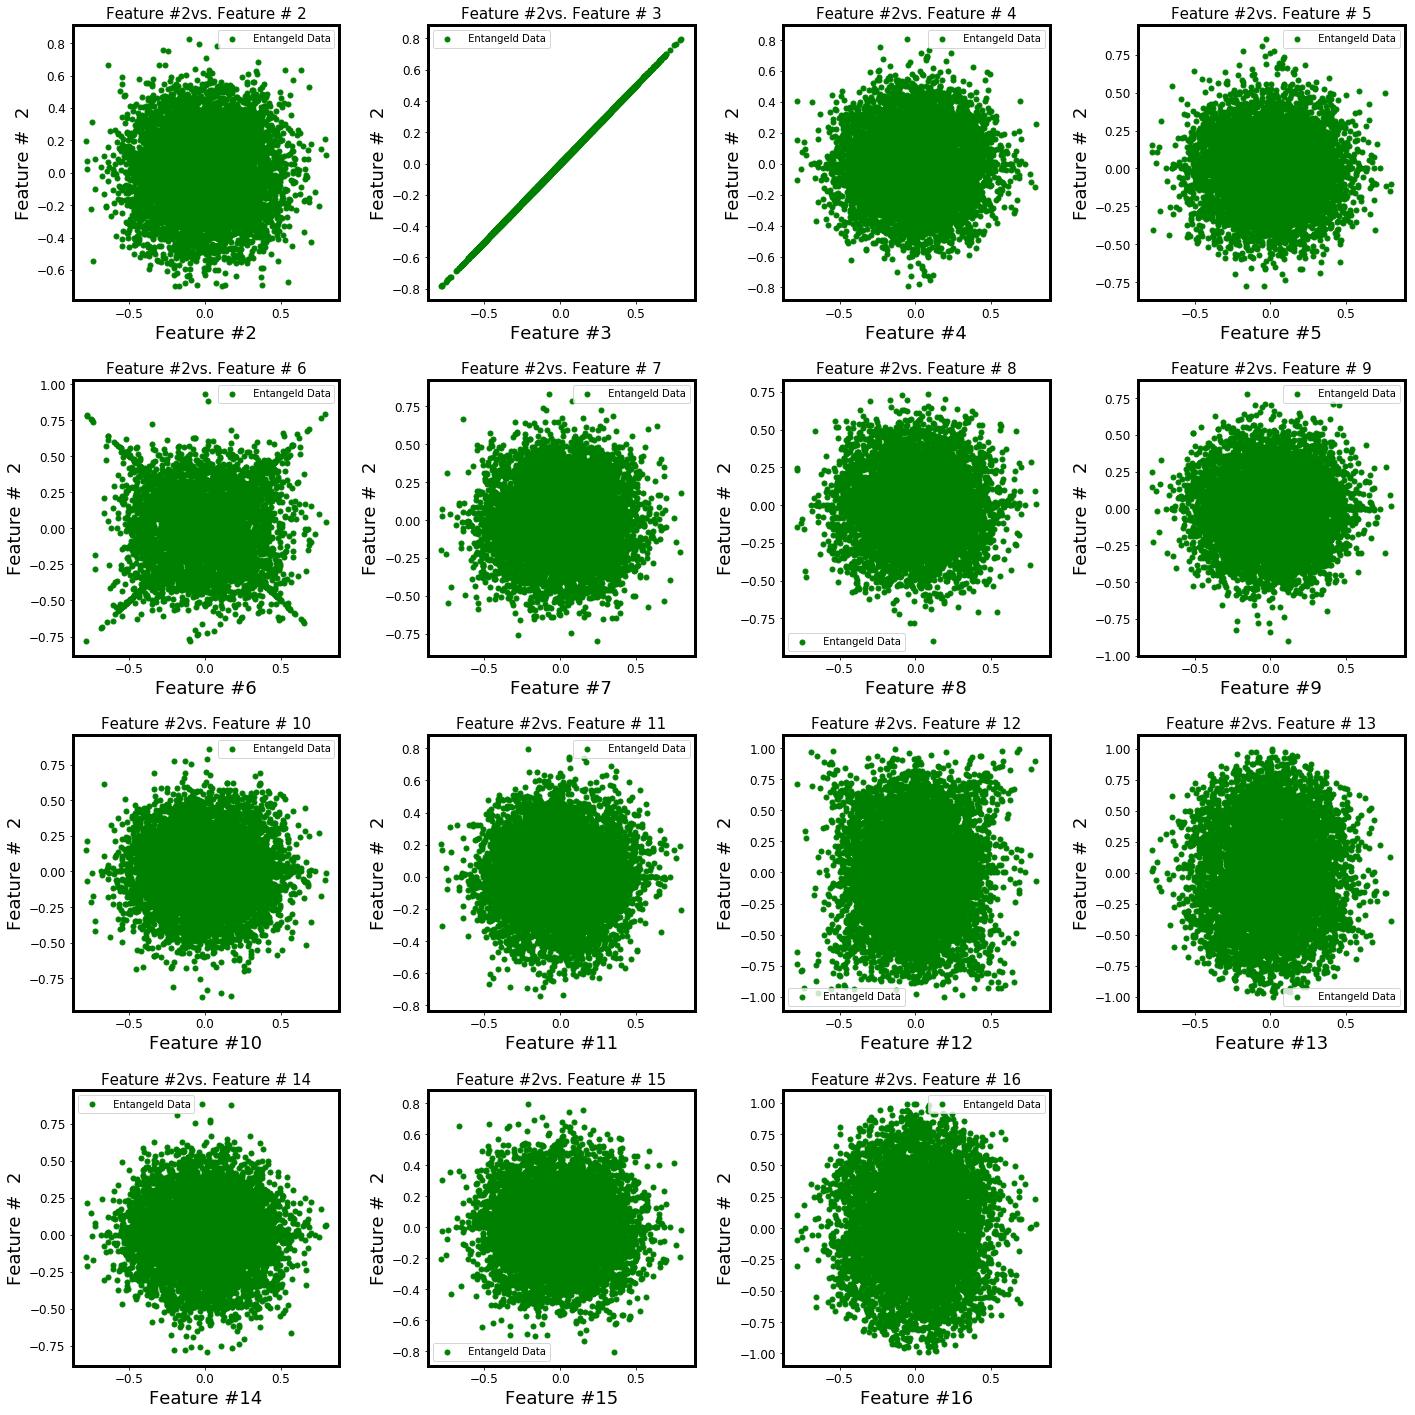

In [12]:
#  Entangled Data
sel = 1

f = plt.figure(figsize=(20,20))
for i in range(n_feature):
    ax = f.add_subplot(4, 4, i + 1, xlabel="Feature #" + str(i+2), ylabel='Feature #  '+str(sel+1), title="Feature #" +str(sel+1) + "vs. Feature # "+ str(i+2) )
    ax.scatter(ent_x[:, sel ] ,ent_x[:, i], color='g',label=' Entangeld Data' )
    ax.legend(loc=0, fontsize = 10)
    
plt.tight_layout()
plt.show()

## Correlation between Features : 

in the following section We calculate the Pearson correlation coefficient for each data to see how Correlated the Data is :

the Pearson correlation coefficient between two values can be calculated using the following formula :

$$ {\rho _x}_ y =\ \frac{COV (X , Y)}{\sigma_x \times \sigma_y} =\ \frac{E[(X-\mu_x)(Y-\mu_y)]}{\sigma_x \times \sigma_y} $$

after calculating the Pearson Correlation Coefficient , we show which Coefficient is bigger :

In [13]:
%%time
# calculating correlation between data :
cor_data = np.empty((n_feature,n_feature))
for i in range (n_feature):
    for j in range (n_feature):
        if i==j:
            cor_data[i , j]= 0
            continue
        else:
            cov  = np.mean(x[:,i]*x[:,j]) - (np.mean(x[:,i])*(np.mean(x[:,j])))
            stds = ((np.std(x[:,i]) )* (np.std(x[:,j])))
            cor_data[i , j]= np.abs(cov/stds)


cor_pd = pd.DataFrame(cor_data)
print (cor_pd.idxmax())

0      5
1     13
2      3
3      2
4     11
5      1
6     13
7     13
8      3
9     14
10    12
11     4
12     8
13     7
14     9
dtype: int64
CPU times: user 70 ms, sys: 489 µs, total: 70.5 ms
Wall time: 69.3 ms


# Data Preparation /  Reduction :

In [14]:
# first we scale the Data using following methods:
X_scaled = scale(x) 

s_scaler = StandardScaler()
X_sscaled = s_scaler.fit_transform(x) 

mm_scaler = MinMaxScaler()
mm_scaler.fit(x)
X_mmscaled = mm_scaler.transform(x) 

r_scaler = RobustScaler()
r_scaler.fit(x)
X_rscaled = r_scaler.transform(x) 

## Spliting Train and Test from data :

In [15]:
X_train , X_test , Y_train , Y_test  = train_test_split(x , y , random_state = 0)

Xs_train , Xs_test , Ys_train , Ys_test  = train_test_split(X_scaled , y , random_state = 0)

Xm_train , Xm_test , Ym_train , Ym_test  = train_test_split(X_sscaled , y , random_state = 0)

Xst_train , Xst_test , Yst_train , Yst_test  = train_test_split(X_mmscaled , y , random_state = 0)

Xr_train , Xr_test , Yr_train , Yr_test  = train_test_split(X_rscaled , y , random_state = 0)

# Regression Method : 

using Cross Validation for the following regression Methods :
1. Linear Regression
2. Decision Tree Regressor
3. Support Vector Machine

### Linear Regression using PolyFeatures (degree=4)

In [16]:
%%time
polytransform = PolynomialFeatures(degree=4 )
reg_nl2 = LinearRegression()
reg_nl2.fit(       (polytransform.fit_transform(X_train))      , Y_train)

CPU times: user 3min 41s, sys: 28.7 s, total: 4min 10s
Wall time: 35.7 s


In [17]:
%%time
print( "the accuracy of Linear Regression is : {} ".format(reg_nl2.score(polytransform.fit_transform(X_test), Y_test)))

the accuracy of Linear Regression is : 1.0 
CPU times: user 567 ms, sys: 402 ms, total: 969 ms
Wall time: 431 ms


in consideration of Data size we dont run cross validation for Linear Regression because of runtime 

### Decision Tree Regressor : 

In [18]:
%%time
tree_reg = DecisionTreeRegressor(max_depth = 8)
tree_reg.fit(X_train,Y_train)
print( "the score on Training Data is {}" .format(tree_reg.score(X_train,Y_train)) )
print( "the score on test Data is {}".format(tree_reg.score(X_test,Y_test)) )
print("the Important Feature of this Regressor is :{}".format(tree_reg.feature_importances_))

the score on Training Data is 0.7938363030641521
the score on test Data is 0.6178022418237359
the Important Feature of this Regressor is :[0.155654   0.20061806 0.00489042 0.00466098 0.19020138 0.13779268
 0.00652965 0.00266473 0.01987302 0.01086376 0.26085064 0.00090533
 0.00057113 0.00138279 0.00254142]
CPU times: user 246 ms, sys: 474 ms, total: 719 ms
Wall time: 145 ms


#### using Cross Validation :

In [19]:
t_reg = DecisionTreeRegressor(max_depth=10)
tree_regscores = cross_validate(t_reg , x, y, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
t_scores = pd.DataFrame(tree_regscores)
print('The result on the original data is: \n {}'.format(  t_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time    test_score   train_score
mean  0.275147    0.001061 -4.406934e-06 -1.464761e-06
std   0.033320    0.000222  8.203604e-07  1.206779e-07


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### SVR:

runtime of SVR for 100000 data is too long so we cant afford this run !

In [20]:
%%time
from sklearn.svm import SVR
svr_nl = SVR(kernel='rbf',degree = 4, epsilon = 0.001 , gamma = 'auto' )
svr_nl.fit(X_train, Y_train )
print( "the score on Training Data is {}" .format(svr_nl.score(X_train,Y_train)) )
print( "the score on test Data is {}".format(svr_nl.score(X_test,Y_test)) )

the score on Training Data is 0.8976534231321601
the score on test Data is 0.8853089672784654
CPU times: user 9.34 s, sys: 17.1 ms, total: 9.36 s
Wall time: 9.35 s


In [ ]:
# using a randomSearch for a better Reggression 


params_dist_SVR = {'C': expon(scale=100), 'gamma': expon(scale=.1),
  'kernel': ['rbf' , 'poly'] , 'epsilon': expon (scale = 0.01) }
svr_reg = SVR()

svr_reg_rs = RandomizedSearchCV(svr_reg, param_distributions=params_dist_SVR, cv=5, n_jobs=-1)

svr_reg_rs.fit(X_train, Y_train)
print(svr_reg_rs.best_params_)
print(svr_reg_rs.best_score_)

# Classification Methods :
using Cross Validation for following Classification Methods :
1. Decision Tree Classifier
2. Ridge Classifier
3. bayes
4. SVC
5. SGD 

In [23]:
X_train , X_test , Y_train , Y_test  = train_test_split(x , yc , random_state = 0)

Xs_train , Xs_test , Ys_train , Ys_test  = train_test_split(X_scaled , yc , random_state = 0)

Xm_train , Xm_test , Ym_train , Ym_test  = train_test_split(X_sscaled , yc , random_state = 0)

Xst_train , Xst_test , Yst_train , Yst_test  = train_test_split(X_mmscaled , yc , random_state = 0)

Xr_train , Xr_test , Yr_train , Yr_test  = train_test_split(X_rscaled , yc , random_state = 0)

### Decision Tree Classifier :

In [24]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,Y_train)

print("The accuracy of the tree classifier is: {}".format( tree_clf.score(X_train,Y_train) ) )
print("The accuracy of the tree classifier is: {}".format( tree_clf.score(X_test,Y_test) ) )

The accuracy of the tree classifier is: 1.0
The accuracy of the tree classifier is: 0.7368


In [26]:
#cross Validation 
t_clf = DecisionTreeClassifier(max_depth=10)
tree_clfscores = cross_validate(t_clf , x, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
t_c_scores = pd.DataFrame(tree_clfscores)
print('The result on the original data is: \n {}'.format(  t_c_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  0.205955    0.000903   -0.258602    -0.152400
std   0.027551    0.000183    0.012521     0.002533


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## Random Forest :

In [27]:
from sklearn.ensemble import RandomForestClassifier
rdm_fo = RandomForestClassifier(n_estimators = 100)
rdm_fo.fit(X_train , Y_train)
print(rdm_fo.score(X_train , Y_train))
print(rdm_fo.score(X_test , Y_test))

1.0
0.834


In [28]:
rdmf_clf = RandomForestClassifier(n_estimators = 100)
rdmfI_clfscores = cross_validate(rdmf_clf , x, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
rdmfI_scores = pd.DataFrame(rdmfI_clfscores)
print('The result on the original data is: \n {}'.format(  rdmfI_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  3.811201    0.038377   -0.172103          0.0
std   0.684527    0.005594    0.010315          0.0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## Ridge Classifier :

In [29]:
polytransform = PolynomialFeatures(degree=4 )
lrg = RidgeClassifier()
lrg.fit( (polytransform.fit_transform(X_train)) , Y_train)
print(lrg.score( (polytransform.fit_transform(X_train)) , Y_train ))
print(lrg.score( (polytransform.fit_transform(X_test)) , Y_test ))

0.8786666666666667
0.8448


In [30]:
ridge_clf = RidgeClassifier()
ridge_clfscores = cross_validate(ridge_clf , x, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=5)
ridge_scores = pd.DataFrame(ridge_clfscores)
print('The result on the original data is: \n {}'.format(  ridge_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  0.044641     0.00271    -0.32610    -0.326100
std   0.029119     0.00290     0.00015     0.000038


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## SVC : 

because of the data size we can't afford this run !.

In [31]:
from sklearn.svm import SVC
svc_clf = SVC(kernel='rbf',degree = 4, gamma = 'auto')
svc_clf.fit(X_train,Y_train )
svc_clf.score(X_test , Y_test)

0.736

In [32]:
# using a randomSearch for a better Classification 

from scipy.stats import expon

params_dist = {'C': expon(scale=100), 'gamma': expon(scale=.1),
  'kernel': ['rbf' , 'poly']}
svc_clf1 = SVC()

svc_clf1_rs = RandomizedSearchCV(svc_clf1, param_distributions=params_dist, cv=5, n_jobs=-1)

svc_clf1_rs.fit(X_train, Y_train)
print(svc_clf1_rs.best_params_)
print(svc_clf1_rs.best_score_)

KeyboardInterrupt: 

In [ ]:
svcI_clf = SVC()
svcI_clfscores = cross_validate(svcI_clf , x, y, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
svcI_scores = pd.DataFrame(svcI_clfscores)
print('The result on the original data is: \n {}'.format(  svcI_scores.describe().loc[['mean','std']] ) )

## Bayes:

In [33]:
from sklearn.naive_bayes import GaussianNB
by_clf = GaussianNB()
by_clf.fit(Xr_train , Yr_train)
by_clf.score(Xr_test , Yr_test)

0.8264

In [34]:
from scipy.stats import expon 
params_dist_b = {'priors' : [None ] , 'var_smoothing':expon(scale = 10**-5)}
by_clf1 = GaussianNB()

by_clf1_rs = RandomizedSearchCV(by_clf1, param_distributions=params_dist_b, cv=6, n_jobs=-1)

by_clf1_rs.fit(X_train, Y_train)
print(by_clf1_rs.best_params_)
print(by_clf1_rs.best_score_)

{'priors': None, 'var_smoothing': 7.582751951913936e-06}
0.8186666666666667


In [36]:
byI_clf = GaussianNB()
byI_clfscores = cross_validate(byI_clf , x, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
byI_scores = pd.DataFrame(byI_clfscores)
print('The result on the original data is: \n {}'.format(  byI_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  0.014337    0.001591   -0.178802    -0.177078
std   0.001954    0.000449    0.009998     0.001456


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## SGD:

In [37]:
polytransform = PolynomialFeatures(degree=4 )

sgd_clf = SGDClassifier(max_iter=10, tol=.15)
sgd_clf.fit(polytransform.fit_transform(Xst_train),Yst_train)

print(sgd_clf.score(polytransform.fit_transform(Xst_test),Yst_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.7488


In [ ]:
# using a randomSearch for a better Classification 
params_dist_SGD = { 'penalty':['none', 'l2', 'l1'],
  'alpha':expon(scale = 0.001) , 'max_iter':[10 , 20 , 30 , 40 , 50 , 60 ] , 'tol' :expon(scale =0.001) , 'epsilon': expon(scale = 0.01) }
sgd_clf = SGDClassifier()

sgd_clf_rs = RandomizedSearchCV(sgd_clf, param_distributions=params_dist_SGD, cv=5, n_jobs=-1)

sgd_clf_rs.fit(X_train, Y_train)
print(sgd_clf_rs.best_params_)
print(sgd_clf_rs.best_score_)

In [ ]:
sgdI_clf = SGDClassifier()
sgdI_clfscores = cross_validate(sgdI_clf , x, y, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
sgdI_scores = pd.DataFrame(sgdI_clfscores)
print('The result on the original data is: \n {}'.format(  sgdI_scores.describe().loc[['mean','std']] ) )

# Data Reduction using PCA :

In [38]:
from sklearn.decomposition import PCA

In [39]:
n_c = 10  ## # components we want to keep. 
pca = PCA(n_components=n_c)
pca.fit(Xr_train)

reduced_Xr_train = pca.transform(Xr_train)
print (reduced_Xr_train.shape)

(7500, 10)


In [40]:
reduced_Xr_test = pca.transform(Xr_test)
redc_Xr_test = pca.inverse_transform(reduced_Xr_test)

redc_Xr_train = pca.inverse_transform(reduced_Xr_train)

In [41]:
pca_t = PCA(n_components=n_c)
pca_t.fit(x)

reduced_x = pca.transform(x)
redc_X = pca.inverse_transform(reduced_x)

## using Classification :

### Ridge Classifier:


In [42]:
polytransform = PolynomialFeatures(degree=4 )
lrg_1 = RidgeClassifier()
lrg_1.fit( (polytransform.fit_transform(redc_Xr_train)) , Y_train)
print(lrg_1.score( (polytransform.fit_transform(redc_Xr_train)) , Y_train ))
print(lrg_1.score( (polytransform.fit_transform(redc_Xr_test)) , Y_test ))

0.7965333333333333
0.7472


In [44]:
ridge_clf = RidgeClassifier()
ridge_clfscores = cross_validate(ridge_clf , redc_X, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
ridge_scores = pd.DataFrame(ridge_clfscores)
print('The result on the original data is: \n {}'.format(  ridge_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  0.029248    0.004935   -0.326100    -0.326100
std   0.011240    0.004891    0.000226     0.000025


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### SGD:

In [45]:
sgdI_clf = SGDClassifier()
sgdI_clfscores = cross_validate(sgdI_clf , redc_X, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
sgdI_scores = pd.DataFrame(sgdI_clfscores)
print('The result on the original data is: \n {}'.format(  sgdI_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  0.018211    0.031271   -0.327598    -0.326967
std   0.010619    0.029174    0.004941     0.002603


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Bayes:

In [46]:
from sklearn.model_selection import cross_validate
byII_clf = GaussianNB()
byII_clfscores = cross_validate(byII_clf , redc_X, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
byII_scores = pd.DataFrame(byII_clfscores)
print('The result on the original data is: \n {}'.format(  byII_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score  train_score
mean  0.009706    0.001562   -0.257302    -0.256167
std   0.001881    0.000478    0.012750     0.001071


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Random Forest

In [48]:
rdm_fo = RandomForestClassifier(n_estimators = 100)
rdm_fo.fit(redc_Xr_train , Y_train)
print(rdm_fo.score(redc_Xr_train , Y_train))
print(rdm_fo.score(redc_Xr_test , Y_test))

1.0
0.7644


In [50]:
rdmfII_clf = RandomForestClassifier(n_estimators = 200)
rdmfII_clfscores = cross_validate(rdmfII_clf ,  redc_X, yc, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
rdmfII_scores = pd.DataFrame(rdmfII_clfscores)
print('The result on the reduced data is: \n {}'.format(  rdmfII_scores.describe().loc[['mean','std']] ) )

The result on the reduced data is: 
       fit_time  score_time  test_score  train_score
mean  8.932119    0.082987   -0.232401          0.0
std   1.607184    0.013348    0.009267          0.0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## Using Regression Method with reduced Data:

### Linear Regression:

In [51]:
%%time 
polytransform1 = PolynomialFeatures(degree=4 )
reg_nl3 = LinearRegression()
reg_nl3.fit(       (polytransform1.fit_transform(redc_Xr_train))      , Yr_train)

CPU times: user 3min 36s, sys: 24.5 s, total: 4min 1s
Wall time: 32.6 s


In [52]:
print (reg_nl3.score(polytransform1.fit_transform(redc_Xr_test) , Yr_test))

0.12799659500602445


### Decision Tree Regressor:

In [53]:
%%time 
t_reg = DecisionTreeRegressor(max_depth=10)
tree_regscores = cross_validate(t_reg , redc_X, y, n_jobs=-1, scoring='neg_mean_squared_error' , cv=10)
t_scores = pd.DataFrame(tree_regscores)
print('The result on the original data is: \n {}'.format(  t_scores.describe().loc[['mean','std']] ) )

The result on the original data is: 
       fit_time  score_time  test_score   train_score
mean  0.234704    0.000732   -0.000007 -3.186997e-06
std   0.043742    0.000127    0.000002  2.375200e-07
CPU times: user 69.8 ms, sys: 919 µs, total: 70.7 ms
Wall time: 454 ms


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


# Table of Comparision : 
in this section we gather the Scores from several Methods (Regression and Classification) used above 
and show them in a Table :

with Saved in ".npy" Format we stored 100000 Data 
in which some Algorithms Can't Process Quick Enough ! 

#### without Reduction :

Regression Methods :\begin{array}{rr} \hline
Regressor :  &LinearReg (degree = 4)  &Decision Tree Reg & Svr  \\ \hline
neg Mean Squared Error  :  & 0  & -3.041328\times10^{-6} + 1.261697\times10^{-7}  &TimeOut \\ \hline
\end{array}

Classification Methods :\begin{array}{rr} \hline
Classifier :  &Decision Tree  &Random Forest  &Ridge Classifier (degree =4) & Svc & Bayes & Sgd \\ \hline
neg Mean Squared Error :  & -0.228770+0.004596  & -0.134000+0.003466  &-0.318060+0.000027 & Timeout & -0.177160+0.003275 & -0.318060+0.000027 \\ \hline
\end{array} 

#### With reduction to 10Features:

Regression Methods :\begin{array}{rr} \hline
Regressor :  &LinearReg (degree = 4)  &Decision Tree Reg & Svr  \\ \hline
neg Mean Squared Error  :  & Score : 0.742  & -5.150108\times10^{-6} +3.257747e\times10^{-7}  &TimeOut \\ \hline
\end{array}
Classification Methods :\begin{array}{rr} \hline
Classifier :  &Ridge Classifier (degree =4)  &Sgd & Bayes & random Forest \\ \hline
neg Mean Squared Error :  & -0.318060+0.000027  & -0.318060+0.000027 &-0.254080+0.003834 & -0.214770+0.002714 \\ \hline
\end{array} 


